In [350]:
import wmfdata as wmf
import pandas as pd
import numpy as np
from wmfdata import spark,hive
from datetime import datetime

In [351]:
file = "https://analytics.wikimedia.org/published/datasets/knowledge_gaps/content_gaps/csv/geography_wmf_region.csv"
geodata = pd.read_csv(file)

# filter for wikipedia projects
wikis=pd.read_csv('data/wikis')
geodata=geodata[geodata.wiki_db.isin(list(wikis['database_code']))]

In [352]:
# Since each snapshot contains patial data of the month it is published it in: we filter the data from previous month if the data was pulled too early. *Needs to be double checked.

# Convert 'time_bucket' to datetime for comparison
#geodata['time_bucket'] = pd.to_datetime(geodata['time_bucket'])


# If today's day is before the 23rd of the month, filter out the previous month's data.  
#if datetime.now().day < 23:
#    prev_month = datetime.now().month - 1 if datetime.now().month > 1 else 12
#    geodata = geodata[geodata['time_bucket'].dt.month != prev_month]

In [353]:
old_geo_data = pd.read_csv('data/updated_geo_data.csv') # load current geo_data table

old_geo_data['time'] = pd.to_datetime(old_geo_data['time'])

old_geo_data # view data

,time,Latin America & Caribbean total,Central & Eastern Europe & Central Asia total,"East, Southeast Asia, & Pacific total",North America total,Northern & Western Europe total,Middle East & North Africa total,Sub-Saharan Africa total,South Asia total,UNCLASSED total,...,"East, Southeast Asia, & Pacific yoy average (3m)",North America yoy average (3m),Northern & Western Europe yoy average (3m),Middle East & North Africa yoy average (3m),Sub-Saharan Africa yoy average (3m),South Asia yoy average (3m),UNCLASSED yoy average (3m),sum,metric_underrepresented,underrepresented
0,2001-01-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
1,2001-02-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
2,2001-03-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
3,2001-04-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
4,2001-05-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2023-04-01,58862,236966,157340,176200,537194,35548,26686,41712,NaN,...,13372.0,11542.0,31550.0,2848.0,2182.0,3435.0,NaN,89531.0,28%,0.282360
268,2023-05-01,59063,238517,158246,176858,540325,35793,26930,42151,NaN,...,13139.0,11289.0,34245.0,2885.0,2209.0,3548.0,NaN,91050.0,28%,0.277002
269,2023-06-01,59231,239573,158980,177288,541987,35944,27102,42329,NaN,...,12943.0,10536.0,36515.0,2888.0,2234.0,3616.0,NaN,91540.0,27%,0.273629
270,2023-07-01,59538,242139,160736,178593,546113,36188,27710,42999,265.0,...,13023.0,10030.0,37126.0,2888.0,2380.0,3822.0,NaN,91816.0,28%,0.276401


In [354]:
# Group and pivot the geodata

    
quality_totals = geodata.groupby(['time_bucket', 'category'])['standard_quality_count_value'].sum().reset_index()
quality_totals_pivot = quality_totals.pivot(index='time_bucket', columns='category', values='standard_quality_count_value').reset_index()

quality_totals_pivot['time'] = pd.to_datetime(quality_totals_pivot['time_bucket'])

cols_to_rename = {col: col + " total" for col in quality_totals_pivot.columns if col not in ['time_bucket', 'category', 'time']}
quality_totals_pivot = quality_totals_pivot.rename(columns=cols_to_rename)


quality_totals_pivot= quality_totals_pivot[quality_totals_pivot['time'] != '2023-09-01']

quality_totals_pivot


category,time_bucket,Central & Eastern Europe & Central Asia total,"East, Southeast Asia, & Pacific total",Latin America & Caribbean total,Middle East & North Africa total,North America total,Northern & Western Europe total,South Asia total,Sub-Saharan Africa total,UNCLASSED total,time
0,2001-01,0,0,0,0,0,0,0,0,0,2001-01-01
1,2001-02,0,0,0,0,0,0,0,0,0,2001-02-01
2,2001-03,0,0,0,0,0,0,0,0,0,2001-03-01
3,2001-04,0,0,0,0,0,0,0,0,0,2001-04-01
4,2001-05,0,0,0,0,0,0,0,0,0,2001-05-01
...,...,...,...,...,...,...,...,...,...,...,...
267,2023-04,237364,157856,58867,35431,176454,538260,41826,26946,265,2023-04-01
268,2023-05,238928,158771,59072,35676,177115,541405,42264,27202,265,2023-05-01
269,2023-06,240510,159704,59321,35952,177772,543828,42665,27452,265,2023-06-01
270,2023-07,242139,160736,59538,36188,178593,546113,42999,27710,265,2023-07-01


In [355]:
# Identify the latest 'time' in old_geo_data

latest_time = old_geo_data['time'].max()

# Filter rows from total quality articles where 'time' is greater than latest_time from old_data to identify rows to be added
filtered_rows = quality_totals_pivot[quality_totals_pivot['time'] > latest_time]

# Filter columns of last_row based on columns in geo_data
old_geo_data = pd.concat([old_geo_data, filtered_rows], axis=0, ignore_index=True, sort=False)

old_geo_data = old_geo_data.drop(columns="time_bucket")

old_geo_data # display data


,time,Latin America & Caribbean total,Central & Eastern Europe & Central Asia total,"East, Southeast Asia, & Pacific total",North America total,Northern & Western Europe total,Middle East & North Africa total,Sub-Saharan Africa total,South Asia total,UNCLASSED total,...,"East, Southeast Asia, & Pacific yoy average (3m)",North America yoy average (3m),Northern & Western Europe yoy average (3m),Middle East & North Africa yoy average (3m),Sub-Saharan Africa yoy average (3m),South Asia yoy average (3m),UNCLASSED yoy average (3m),sum,metric_underrepresented,underrepresented
0,2001-01-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
1,2001-02-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
2,2001-03-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
3,2001-04-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
4,2001-05-01,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2023-04-01,58862,236966,157340,176200,537194,35548,26686,41712,NaN,...,13372.0,11542.0,31550.0,2848.0,2182.0,3435.0,NaN,89531.0,28%,0.282360
268,2023-05-01,59063,238517,158246,176858,540325,35793,26930,42151,NaN,...,13139.0,11289.0,34245.0,2885.0,2209.0,3548.0,NaN,91050.0,28%,0.277002
269,2023-06-01,59231,239573,158980,177288,541987,35944,27102,42329,NaN,...,12943.0,10536.0,36515.0,2888.0,2234.0,3616.0,NaN,91540.0,27%,0.273629
270,2023-07-01,59538,242139,160736,178593,546113,36188,27710,42999,265.0,...,13023.0,10030.0,37126.0,2888.0,2380.0,3822.0,NaN,91816.0,28%,0.276401


In [356]:
# check if new data was appended to the original csv file.

if filtered_rows.empty:
    print("No data has been added to the original spreadsheet. Will not overwrite updated_geo_data.csv")
    

else:
    # Compute yoy difference and 3m moving average

    old_geo_data['Latin America & Caribbean yoy average (3m)'] = old_geo_data['Latin America & Caribbean total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['Central & Eastern Europe & Central Asia yoy average (3m)'] = old_geo_data['Central & Eastern Europe & Central Asia total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['East, Southeast Asia, & Pacific yoy average (3m)'] = old_geo_data['East, Southeast Asia, & Pacific total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['North America yoy average (3m)'] = old_geo_data['North America total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['Northern & Western Europe yoy average (3m)'] = old_geo_data['Northern & Western Europe total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['Middle East & North Africa yoy average (3m)'] = old_geo_data['Middle East & North Africa total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['Sub-Saharan Africa yoy average (3m)'] = old_geo_data['Sub-Saharan Africa total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['South Asia yoy average (3m)'] = old_geo_data['South Asia total'].diff(12).rolling(window=3).mean().round(0)
    old_geo_data['UNCLASSED yoy average (3m)'] = old_geo_data['UNCLASSED total'].diff(12).rolling(window=3).mean().round(0)

    
    # Get a list of columns that contain 'yoy average (3m)'
    yoy_columns = [col for col in old_geo_data.columns if 'yoy average (3m)' in col]

    # Sum the yoy 3m moving average columns
    old_geo_data['sum'] = old_geo_data[yoy_columns].sum(axis=1)
    
    

    # List of underrepresented regions
    underrepresented_regions = [
        "East, Southeast Asia, & Pacific yoy average (3m)", 
        "Latin America & Caribbean yoy average (3m)", 
        "Middle East & North Africa yoy average (3m)" , 
        "South Asia yoy average (3m)", 
        "Sub-Saharan Africa yoy average (3m)"
    ]

    # Compute the sum of underrepresented regions
    old_geo_data['underrepresented_sum'] = old_geo_data[underrepresented_regions].sum(axis=1)

    # Calculate the proportion of underrepresented regions to total
    old_geo_data['metric_underrepresented'] = old_geo_data['underrepresented_sum'] / old_geo_data['sum']

    # drop underrepresented sum
    old_geo_data.drop('underrepresented_sum', axis=1, inplace=True)
    
    # round and turn into percentage
    old_geo_data['underrepresented'] = old_geo_data['metric_underrepresented'] 
    old_geo_data['metric_underrepresented'] = (old_geo_data['metric_underrepresented'] * 100).round()
    old_geo_data['metric_underrepresented'] = old_geo_data['metric_underrepresented'].replace([np.inf, -np.inf, np.nan], 0).astype(int).astype(str) + '%'
    
    # output
    print("updating csv file")
    old_geo_data.to_csv('data/updated_geo_data.csv', index=False)
    


No data has been added to the original spreadsheet. Will not overwrite updated_geo_data.csv


In [357]:
old_geo_data.tail()

,time,Latin America & Caribbean total,Central & Eastern Europe & Central Asia total,"East, Southeast Asia, & Pacific total",North America total,Northern & Western Europe total,Middle East & North Africa total,Sub-Saharan Africa total,South Asia total,UNCLASSED total,...,"East, Southeast Asia, & Pacific yoy average (3m)",North America yoy average (3m),Northern & Western Europe yoy average (3m),Middle East & North Africa yoy average (3m),Sub-Saharan Africa yoy average (3m),South Asia yoy average (3m),UNCLASSED yoy average (3m),sum,metric_underrepresented,underrepresented
267,2023-04-01,58862,236966,157340,176200,537194,35548,26686,41712,NaN,...,13372.0,11542.0,31550.0,2848.0,2182.0,3435.0,NaN,89531.0,28%,0.282360
268,2023-05-01,59063,238517,158246,176858,540325,35793,26930,42151,NaN,...,13139.0,11289.0,34245.0,2885.0,2209.0,3548.0,NaN,91050.0,28%,0.277002
269,2023-06-01,59231,239573,158980,177288,541987,35944,27102,42329,NaN,...,12943.0,10536.0,36515.0,2888.0,2234.0,3616.0,NaN,91540.0,27%,0.273629
270,2023-07-01,59538,242139,160736,178593,546113,36188,27710,42999,265.0,...,13023.0,10030.0,37126.0,2888.0,2380.0,3822.0,NaN,91816.0,28%,0.276401
271,2023-08-01,59840,243669,162059,179267,548327,36411,28039,43486,267.0,...,13159.0,9543.0,37342.0,2890.0,2569.0,3994.0,NaN,91814.0,28%,0.281221


# Naive Forecast

In [358]:
# Get the value for June 2023 and August 2023
june_val = old_geo_data[old_geo_data['time'] == '2023-06-01']['underrepresented'].values[0]
aug_val = old_geo_data[old_geo_data['time'] == '2023-08-01']['underrepresented'].values[0]

# Calculate the difference and round it to the nearest 0.01
diff = round(aug_val - june_val, 2)

# Create a new DataFrame for the forecast
forecast_data = pd.DataFrame({
    'time': ['2023-10', '2023-11', '2023-12'],
    'delta_QoQ': [diff, diff, diff]
})

# Get the last month's value
last_month_val = old_geo_data.iloc[-1]['underrepresented']

# Calculate the forecasted values
forecast_data['forecasted_values'] = (last_month_val + forecast_data['delta_QoQ']) * 100
forecast_data['forecasted_values'] = forecast_data['forecasted_values'].round(0).astype(int).astype(str) + "%"

print(forecast_data.iloc[-1])

time                 2023-12
delta_QoQ               0.01
forecasted_values        29%
Name: 2, dtype: object


# Monthly Metric Graph

Generating region chart..
           time  Latin America & Caribbean total  \
0    2001-01-01                                0   
1    2001-02-01                                0   
2    2001-03-01                                0   
3    2001-04-01                                0   
4    2001-05-01                                0   
..          ...                              ...   
267  2023-04-01                            58862   
268  2023-05-01                            59063   
269  2023-06-01                            59231   
270  2023-07-01                            59538   
271  2023-08-01                            59840   

     Central & Eastern Europe & Central Asia total  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
..                       

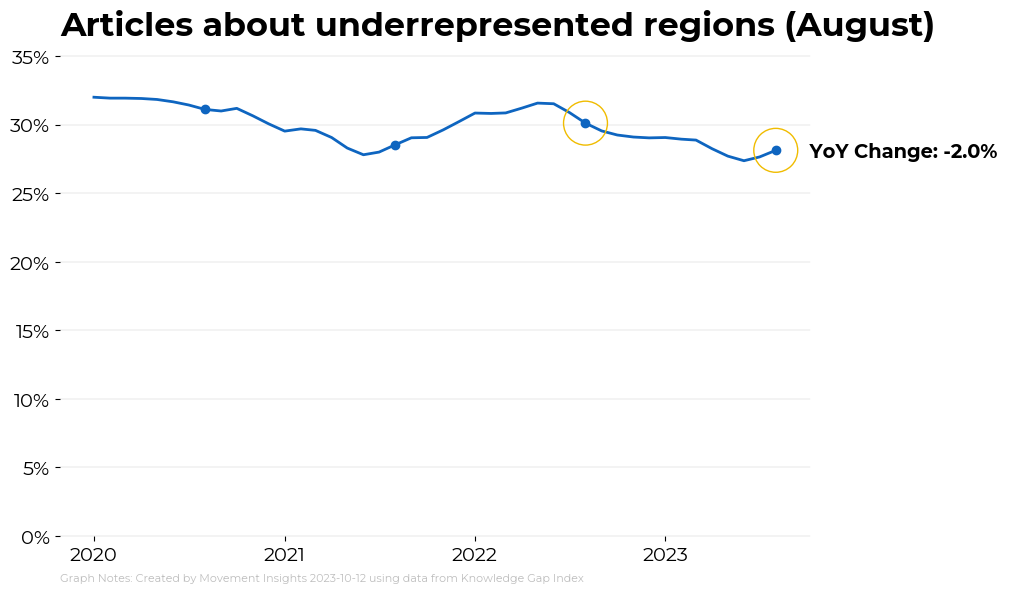

In [359]:
%run geo_data_plot.ipynb